
### Analysis of Sensor Measurement Correlation
<br><br>

<br>

##Introduction

Signals in the context of time series data represent a sequence of measurements taken over time. These measurements can come from various domains like weather forecast , Stock market etc. Time series analysis deals with understanding and analyzing data that is collected over time. It assumes that the data is weakly stationary, meaning that the expected value of the series remains constant over time, and the covariance between observations depends only on the time lag between them.

##Cross-Correlation
Cross-correlation measures the similarity between two signals as a function of a time lag. It helps in identifying patterns or relationships between two time series. Mathematically, cross-correlation is computed by sliding one signal over the other and calculating the similarity at each lag or time interval.​

##Data Set​
- Dataset: Air quality dataset containing 9471 measurements from sensor for various pollutants and environmental parameters.​
- Features: This includes 12 features or mesurments taken on different time lag. It includes measurements such as CO, NOx, temperature, humidity, etc.​​
- Time Series Data: Each observation represents sensor readings at a specific time interval​

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:


# Load the dataset from the ZIP file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"

# Download the ZIP file
response = requests.get(url)
zipped_data = zipfile.ZipFile(io.BytesIO(response.content))


zipped_files = zipped_data.namelist()
csv_file = [file for file in zipped_files if file.endswith('.csv')][0]
with zipped_data.open(csv_file) as f:
    air_quality_data = pd.read_csv(f, sep=';', decimal=',', na_values=-200)

# Drop NMHC(GT) feature due to many missing values
air_quality_data.drop(columns=['NMHC(GT)'], inplace=True)


In [ ]:
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


##Preprocessing
- **Handling Missing Values:** Using forward fill for consecutive missing observations and backfill for remaining missing values to preserves the temporal structure of the data and minimizes data loss.

- **Feature Selection:** Due to a high number of missing values, NMHC(GT) feature is dropped from the analysis.


In [ ]:
# Impute missing values
# Forward fill missing values for consecutive missing observations
air_quality_data.fillna(method='ffill', inplace=True)
# Backward fill remaining missing values
air_quality_data.fillna(method='bfill', inplace=True)

air_quality_data.drop(columns=['Date', 'Time'], inplace=True)
air_quality_data = air_quality_data.loc[:, ~air_quality_data.columns.str.contains('^Unnamed')]
air_quality_data.shape

(9471, 12)

## Correlation Coefficient

1. **Input**: Two arrays of data, \(x\) and \(y\).
2. **Mean Calculation**: Here  the mean is calculated by using (\( $\mu_x $\) and \( $\mu_y $\)) of arrays \( x \) and \( y \) respectively using the formula:
   - $( \mu_x = \frac{1}{n} \sum_{i=1}^{n} x_i $\)
   - $( \mu_y = \frac{1}{n} \sum_{i=1}^{n} y_i $\)
   where \( n \) is the number of data points.
3. **Numerator Calculation**: The numerator of the correlation coefficient
    \$( \text{numerator} = \sum_{i=1}^{n} (x_i - \mu_x) \cdot (y_i - \mu_y) \$)
4. **Denominator Calculation**: The denominator of the correlation coefficient
    \$( \text{denominator} = \sqrt{\sum_{i=1}^{n} (x_i - \mu_x)^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \mu_y)^2} \$)
5. **Correlation Coefficient Calculation**: The correlation coefficient ($\( r \))  will be
    \$( r = $\frac{\text{numerator}}{\text{denominator}} $\) if \$(\text{denominator} \neq 0 $\), else \( r = 0 \).
6. **Output**: Return the correlation coefficient \( r \).



In [ ]:
def calculat_correlation(x, y):

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x) ** 2) * np.sum((y - mean_y) ** 2))

    correlation_coefficient = numerator / denominator if denominator != 0 else 0

    return correlation_coefficient


In [ ]:
sensor_columns = air_quality_data.columns
sensor_columns

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')

In [ ]:
# Compute cross-correlation
correlation_values = np.zeros((len(sensor_columns), len(sensor_columns)))
for i, sensor1 in enumerate(sensor_columns):
    for j, sensor2 in enumerate(sensor_columns):
        correlation_values[i, j] = calculat_correlation(air_quality_data[sensor1], air_quality_data[sensor2])
correlation_values

array([[ 1.        ,  0.76298244,  0.7790046 ,  0.76873078,  0.78788074,
        -0.61926676,  0.68849684,  0.50885578,  0.73525185,  0.00260915,
         0.03900576,  0.02185679],
       [ 0.76298244,  1.        ,  0.88554822,  0.89442071,  0.64418168,
        -0.77432534,  0.57340001,  0.6744282 ,  0.9007779 ,  0.03475591,
         0.1205708 ,  0.12273136],
       [ 0.7790046 ,  0.88554822,  1.        ,  0.98234937,  0.63769614,
        -0.73721088,  0.53571039,  0.74964583,  0.85859687,  0.19119816,
        -0.05904243,  0.15086072],
       [ 0.76873078,  0.89442071,  0.98234937,  1.        ,  0.62652354,
        -0.79831391,  0.56643751,  0.76077296,  0.8719348 ,  0.23438156,
        -0.08935425,  0.16722124],
       [ 0.78788074,  0.64418168,  0.63769614,  0.62652354,  1.        ,
        -0.60722232,  0.75858357,  0.19208275,  0.7068066 , -0.24049532,
         0.17703505, -0.14284964],
       [-0.61926676, -0.77432534, -0.73721088, -0.79831391, -0.60722232,
         1.        , -

##Sensor Analysis​

In the provided cross-correlation matrix, each cell represents the correlation coefficient between two sensors. A correlation coefficient close to 1 indicates a strong positive correlation, while a value close to -1 indicates a strong negative correlation and 0 is no correlation.​

In [ ]:
# Convert correlation values to DataFrame
correlation_matrix= pd.DataFrame(correlation_values, columns=sensor_columns, index=sensor_columns)
correlation_matrix

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.762982,0.779005,0.768731,0.787881,-0.619267,0.688497,0.508856,0.735252,0.002609,0.039006,0.021857
PT08.S1(CO),0.762982,1.000000,0.885548,0.894421,0.644182,-0.774325,0.573400,0.674428,0.900778,0.034756,0.120571,0.122731
C6H6(GT),0.779005,0.885548,1.000000,0.982349,0.637696,-0.737211,0.535710,0.749646,0.858597,0.191198,-0.059042,0.150861
PT08.S2(NMHC),0.768731,0.894421,0.982349,1.000000,0.626524,-0.798314,0.566438,0.760773,0.871935,0.234382,-0.089354,0.167221
NOx(GT),0.787881,0.644182,0.637696,0.626524,1.000000,-0.607222,0.758584,0.192083,0.706807,-0.240495,0.177035,-0.142850
PT08.S3(NOx),-0.619267,-0.774325,-0.737211,-0.798314,-0.607222,1.000000,-0.595412,-0.523141,-0.787956,-0.141020,-0.042076,-0.203469
NO2(GT),0.688497,0.573400,0.535710,0.566438,0.758584,-0.595412,1.000000,0.091798,0.619034,-0.174286,-0.125027,-0.351238
PT08.S4(NO2),0.508856,0.674428,0.749646,0.760773,0.192083,-0.523141,0.091798,1.000000,0.581061,0.538283,0.007712,0.635048
PT08.S5(O3),0.735252,0.900778,0.858597,0.871935,0.706807,-0.787956,0.619034,0.581061,1.000000,-0.051585,0.146812,0.062759
T,0.002609,0.034756,0.191198,0.234382,-0.240495,-0.141020,-0.174286,0.538283,-0.051585,1.000000,-0.580019,0.625999


In [ ]:
# Report analysis
print("Cross-Correlation Matrix :")
print(correlation_matrix)


Cross-Correlation Matrix :
                 CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
CO(GT)         1.000000     0.762982  0.779005       0.768731  0.787881   
PT08.S1(CO)    0.762982     1.000000  0.885548       0.894421  0.644182   
C6H6(GT)       0.779005     0.885548  1.000000       0.982349  0.637696   
PT08.S2(NMHC)  0.768731     0.894421  0.982349       1.000000  0.626524   
NOx(GT)        0.787881     0.644182  0.637696       0.626524  1.000000   
PT08.S3(NOx)  -0.619267    -0.774325 -0.737211      -0.798314 -0.607222   
NO2(GT)        0.688497     0.573400  0.535710       0.566438  0.758584   
PT08.S4(NO2)   0.508856     0.674428  0.749646       0.760773  0.192083   
PT08.S5(O3)    0.735252     0.900778  0.858597       0.871935  0.706807   
T              0.002609     0.034756  0.191198       0.234382 -0.240495   
RH             0.039006     0.120571 -0.059042      -0.089354  0.177035   
AH             0.021857     0.122731  0.150861       0.167221 -0.142850  

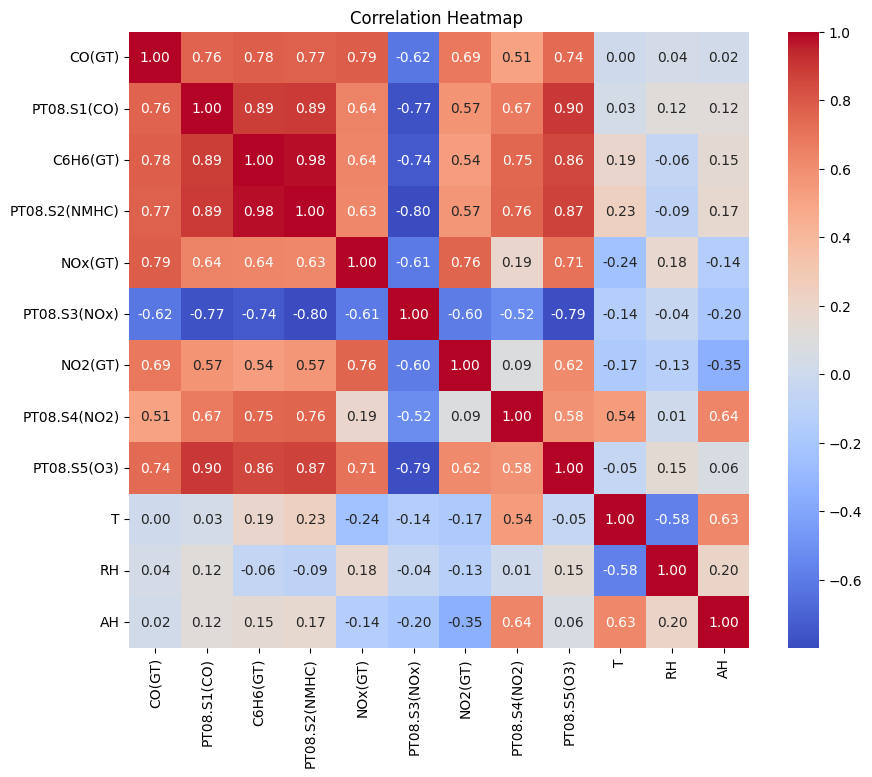

In [ ]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap ')
plt.show()

##Mean Cross-Correlation
 The bar plot of mean cross-correlation provides insights into the average correlation of each sensor with others where we can see the sensors with higher overall correlations.

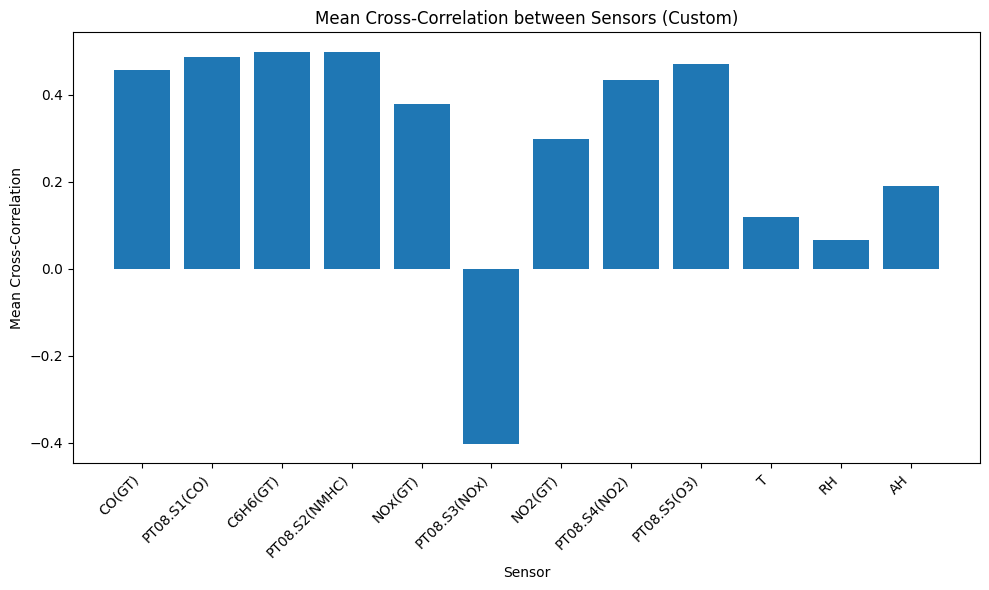

In [ ]:

# Plot mean cross-correlation values
mean_correlation= correlation_matrix.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(mean_correlation.index, mean_correlation.values)
plt.xlabel('Sensor')
plt.ylabel('Mean Cross-Correlation')
plt.title('Mean Cross-Correlation between Sensors (Custom)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


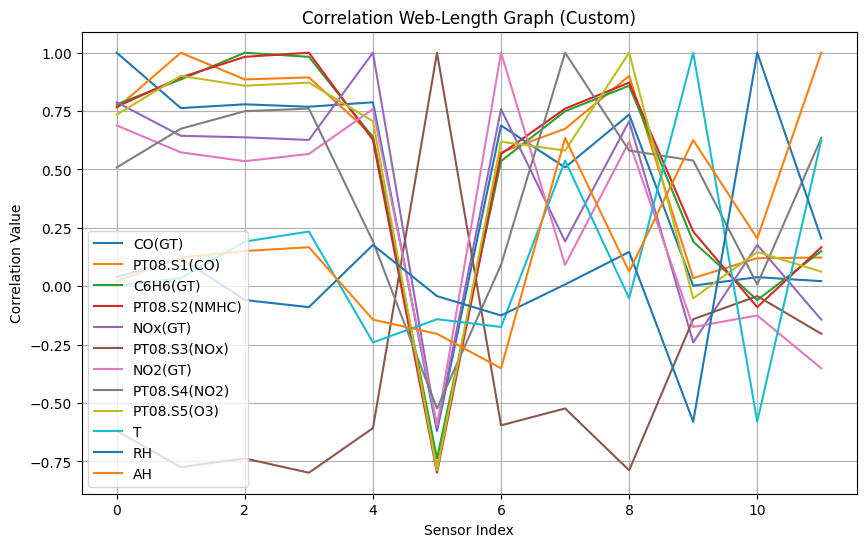

In [ ]:
# Web-length graph
plt.figure(figsize=(10, 6))
for i, row in enumerate(correlation_matrix.values):
    plt.plot(np.arange(len(row)), row, label=correlation_matrix.index[i])

plt.xlabel('Sensor Index')
plt.ylabel('Correlation Value')
plt.title('Correlation Web-Length Graph (Custom)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
correlation_matrix

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.762982,0.779005,0.768731,0.787881,-0.619267,0.688497,0.508856,0.735252,0.002609,0.039006,0.021857
PT08.S1(CO),0.762982,1.000000,0.885548,0.894421,0.644182,-0.774325,0.573400,0.674428,0.900778,0.034756,0.120571,0.122731
C6H6(GT),0.779005,0.885548,1.000000,0.982349,0.637696,-0.737211,0.535710,0.749646,0.858597,0.191198,-0.059042,0.150861
PT08.S2(NMHC),0.768731,0.894421,0.982349,1.000000,0.626524,-0.798314,0.566438,0.760773,0.871935,0.234382,-0.089354,0.167221
NOx(GT),0.787881,0.644182,0.637696,0.626524,1.000000,-0.607222,0.758584,0.192083,0.706807,-0.240495,0.177035,-0.142850
PT08.S3(NOx),-0.619267,-0.774325,-0.737211,-0.798314,-0.607222,1.000000,-0.595412,-0.523141,-0.787956,-0.141020,-0.042076,-0.203469
NO2(GT),0.688497,0.573400,0.535710,0.566438,0.758584,-0.595412,1.000000,0.091798,0.619034,-0.174286,-0.125027,-0.351238
PT08.S4(NO2),0.508856,0.674428,0.749646,0.760773,0.192083,-0.523141,0.091798,1.000000,0.581061,0.538283,0.007712,0.635048
PT08.S5(O3),0.735252,0.900778,0.858597,0.871935,0.706807,-0.787956,0.619034,0.581061,1.000000,-0.051585,0.146812,0.062759
T,0.002609,0.034756,0.191198,0.234382,-0.240495,-0.141020,-0.174286,0.538283,-0.051585,1.000000,-0.580019,0.625999


In [ ]:
print("\nFirst 5 correlations (Custom):")
print(correlation_matrix.head())


First 5 correlations (Custom):
                 CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
CO(GT)         1.000000     0.762982  0.779005       0.768731  0.787881   
PT08.S1(CO)    0.762982     1.000000  0.885548       0.894421  0.644182   
C6H6(GT)       0.779005     0.885548  1.000000       0.982349  0.637696   
PT08.S2(NMHC)  0.768731     0.894421  0.982349       1.000000  0.626524   
NOx(GT)        0.787881     0.644182  0.637696       0.626524  1.000000   

               PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T  \
CO(GT)            -0.619267  0.688497      0.508856     0.735252  0.002609   
PT08.S1(CO)       -0.774325  0.573400      0.674428     0.900778  0.034756   
C6H6(GT)          -0.737211  0.535710      0.749646     0.858597  0.191198   
PT08.S2(NMHC)     -0.798314  0.566438      0.760773     0.871935  0.234382   
NOx(GT)           -0.607222  0.758584      0.192083     0.706807 -0.240495   

                     RH        AH  
CO(GT)      

### Finding Most and Least Correlations

- Initialize an empty list correlations to store all pairwise correlations between sensors.
- Iterate over the rows and columns of the correlation matrix using nested loops.
- For each pair of sensors (calculating without self-correlations), calculate the correlation coefficient and append the tuple  to the correlations list.
- Sort the correlations list based on the absolute value of the correlation coefficient in ascending order.
- Extract the five sensor pairs with the least positive correlations and five sensor pairs with the most positive correlations from the sorted list.
- Filter out the sensor pairs with negative correlations to find inverse correlations.
- If there are inverse correlations, identify the pair with the most negative correlation and the pair with the least negative correlation.
- Identify sensor pairs with zero correlation coefficients.
- Return the lists of most positive correlations, least positive correlations, most inverse correlation, least inverse correlation, and sensor pairs with no correlation.


In [ ]:
def find_most_least_correlated(correlation_matrix):
    correlations = []

    for i, sensor1 in enumerate(correlation_matrix.index):
        for j, sensor2 in enumerate(correlation_matrix.columns):
            if i != j:
                correlation = correlation_matrix.loc[sensor1, sensor2]
                correlations.append((sensor1, sensor2, correlation))

    correlations_sorted = sorted(correlations, key=lambda x: abs(x[2]))

    least_positive_correlations = correlations_sorted[:5]
    most_positive_correlations = correlations_sorted[-5:][::-1]

    # Find out inverse correlations
    inverse_correlations = [corr for corr in correlations_sorted if corr[2] < 0]

    # Find the most and least inversely correlated
    if inverse_correlations:
        most_inverse_correlation = inverse_correlations[-1]
        least_inverse_correlation = inverse_correlations[0]
    else:
        most_inverse_correlation = None
        least_inverse_correlation = None

    # Find sensor pairs with zero correlation
    no_correlation_pairs = [(sensor1, sensor2) for sensor1, sensor2, correlation in correlations_sorted if correlation == 0]

    return most_positive_correlations, least_positive_correlations, most_inverse_correlation, least_inverse_correlation, no_correlation_pairs


In [ ]:
most_positive, least_positive, most_inverse, least_inverse, no_correlation = find_most_least_correlated(correlation_matrix)

##Most Positive Correlations

- The strong positive correlations observed between sensors like PT08.S2(NMHC) and C6H6(GT) suggesting a high degree of similarity in there readings. This could indicate that these sensors are sensitive to similar  environmental factors.

- The high correlation between PT08.S5(O3) and PT08.S1(CO) might indicate a relationship between ozone levels and carbon monoxide levels in the air. This could be due to shared sources of pollution.

In [ ]:
print("Most Positive Correlations:")
for pair in most_positive:
    print(f"Pair: {pair[0]} - {pair[1]}, Correlation Coefficient: {pair[2]}")


Most Positive Correlations:
Pair: PT08.S2(NMHC) - C6H6(GT), Correlation Coefficient: 0.9823493704655432
Pair: C6H6(GT) - PT08.S2(NMHC), Correlation Coefficient: 0.9823493704655432
Pair: PT08.S5(O3) - PT08.S1(CO), Correlation Coefficient: 0.9007779019080498
Pair: PT08.S1(CO) - PT08.S5(O3), Correlation Coefficient: 0.9007779019080498
Pair: PT08.S2(NMHC) - PT08.S1(CO), Correlation Coefficient: 0.8944207102264167


###Least Positive Correlations

The weak positive correlations close to zero suggest that these sensor readings are not strongly related to each other in a linearly. This could implys that this sensors are capturing different situations of air quality or are influenced by different other situations.Here the low correlation between CO(GT) and T (temperature) indicates that carbon monoxide levels are not influenced by tetemperature that much.

In [ ]:
print("\nLeast Positive Correlations:")
for pair in least_positive:
    print(f"Pair: {pair[0]} - {pair[1]}, Correlation Coefficient: {pair[2]}")



Least Positive Correlations:
Pair: CO(GT) - T, Correlation Coefficient: 0.002609146349153211
Pair: T - CO(GT), Correlation Coefficient: 0.002609146349153211
Pair: PT08.S4(NO2) - RH, Correlation Coefficient: 0.00771180678509228
Pair: RH - PT08.S4(NO2), Correlation Coefficient: 0.00771180678509228
Pair: CO(GT) - AH, Correlation Coefficient: 0.0218567949849878


### Most Inversely Correlated Positive Pair

The strong negative correlation between PT08.S3(NOx) and PT08.S2(NMHC) suggesting an inverse or negetive relationship between nitrogen oxide levels and non-methane hydrocarbon levels. This could indicate reverse or opositite trends in polutions  or chemical or biographical reactions in the enviornments means if one increased other will be decreased.

In [ ]:
if most_inverse:
    print(f"\nMost Inversely Correlated Positive Pair: {most_inverse[0]} - {most_inverse[1]}, Correlation Coefficient: {most_inverse[2]}")
else:
    print("\nNo Most Inversely Correlated Positive Pair found")



Most Inversely Correlated Positive Pair: PT08.S3(NOx) - PT08.S2(NMHC), Correlation Coefficient: -0.7983139142233101


###Least Inversely Correlated Positive Pair

The weak negative correlation between PT08.S3(NOx) and RH (relative humidity) indicates a small amount of negetive or inverse relationship between nitrogen oxide levels and humidity. However, the correlation coefficient suggests that this relationship is more weak compared to other pairs.

In [ ]:
if least_inverse:
    print(f"Least Inversely Correlated Positive Pair: {least_inverse[0]} - {least_inverse[1]}, Correlation Coefficient: {least_inverse[2]}")
else:
    print("No Least Inversely Correlated Positive Pair found")


Least Inversely Correlated Positive Pair: PT08.S3(NOx) - RH, Correlation Coefficient: -0.04207598180028912


###No Correlation

The absence of pairs with zero correlation coefficients tell us that all sensor readings have some amount of linear relationship with each other. This suggests that there are underlying patterns or influences in the air quality data that are captured by multiple sensors, even if the relationships are weak.

In [ ]:

print("\nPairs with No Correlation:")
for pair in no_correlation:
    print(f"Pair: {pair[0]} - {pair[1]}")


Pairs with No Correlation:


##Weak Aspect
- The analysis could be enhanced by incorporating additional domain knowledge for example how the temperatur affect the sensors or the no level increaseing and decreasing etc to represent the correlation findings effectively.
- Deeper exploration into the dataset's context, such as understanding sensor locations and surroundings, could provide more effectiveness to the analysis because for example the sea side and mountain has different air flow and temperature etc.


##Conclusion

Here the analysis helps to understand the correlation structure of air quality sensors. By doing data-driven analysis, we can optimize sensor deployment strategies and improve the accuracy of air quality monitoring systems.